# GEOL20E HW6: Biogeochemical Modeling

## Introduction

This project builds on a "Superproblem" published in the classic text _Tracers in the Sea_ by Broecker and Peng (1982). Our goal is to understand first-order spatial patterns in marine chemistry by modeling physical and biological dynamics.

Our setup is depicted below: four big tanks as a rather simplified analog of the global ocean. The left column is the combined Indian & Pacific Ocean basins; the right column is the Atlantic. Each basin has a small tank on top for the sunlit surface and a much larger deep zone. Each tank has a letter and a number, the latter being its volume in liters.

Just like in the ocean, water circulates. Black arrows between tanks represent pumps, labeled with volumetric flux in liters per hour. We also have an external pump into reservoir A and drain from reservoir B, which is more dubious as a analog to the real ocean but will play an important role in our first model iteration (and appears in the original problem statement). This might represent something like riverine input and mineral deposition.

Finally, we model biologically-driven nutrient flux, which operates differently than the physical circulation described above. These are the green $F_{bio}$ arrows. Before we examine the biological component, let's start modeling physical circulation.

<img src="schematic.pdf" width=600 />

To start, we import some python libraries. Click to highlight the code box below and press Shift-Return to run.

In [1]:
import numpy as np # mathematics, computing, arrays
from scipy.integrate import odeint # ordinary differential equations
import matplotlib.pyplot as plt # plots

Next, let's define the physical parameters as outlined above: volumes & volumetric fluxes. When you experiment with changing these values, make sure to re-run the cell (Shift-Return) & any other cells that reference these values. Volumes can be redefined freely, but careful if you adjust volumetric fluxes so that the total volume of each reservoir does not change over time. Keep in mind, that these numbers are meant to capture certain aspects about the real ocean: the Indo-Pacific is larger than the Atlantic, most deepwater formation occurs in the Atlantic, the Pacific is dominated by diffuse upwelling, etc. This information will be helpful for your interpretations in the summary at the end of this activity.

In [14]:
# Reservoir Volumes (L)
V = (600, 300, 3000, 6000)

# Volumetric Fluxes (L/hr) AB is from A to B, etc. 
# E = external for in- and outfluxes.
AB = 8
BA = 2
BC = 10
CB = 4
CD = 8
DC = 2

EA = 1
DE = EA

# DA defined differently for "closed" and "open" conditions
# Open: EA and DE as shown in diagram
# Closed: DE goes straight back into EA, essentially adds to existing DA
DAo = 5
DAc = DAo + DE

Remember, we are interested in the chemical evolution of each reservoir. Phosphate will be important as a _biologically_ cycled nutrient, but it is also transported by physical circulation like any other dissolved species. Let's define initial concentrations in a single array for easy use. To start, we also have a volumetrically constant influx from an external source, so we define that composition as well.

In [3]:
# Initial Reservoir [PO4] (umol/L)
phosphate_0 = (2, 2, 2, 2)

initialConditions = phosphate_0

# External influx [PO4] (umol/L)
E = 2

We need to set a time interval over which our model will predict future behavior. We'll define two, since two types of problems we're interested in will operate over different timescales.

In [4]:
t_open = np.arange(0, 100000, 1) # first, last, step interval (hr)
t_closed = np.arange(0, 5000, 1)

Now we are ready to design a model describing the influence of physical circulation on chemical composition. Intuitively, we might expect that this system will be rather boring, especially if every reservoir starts with the same phosphate concentration. But let's take this opportunity to learn the basics of quantitative modelling using a system of differential equations.

## Part I. Modeling Physical Circulation

What's the goal of modeling? The idea is we can predict the states of our system _far into the future_ if we can describe how those components influence one another _at each moment._ Specifically, we will design a system of _differential equations_ in which we express rates (like changes in concentration) in terms of states (like concentrations). It's hard to overstate the predictive and descriptive power of this framework, and it's no coincidence that a huge array of fundamental scientific principles and governing laws are formulated and solved using differential equations.

In our case, the quantities of interest are the phosphate concentrations in each reservoir. It turns out to be easier to model _amounts_ (umol) of nutrient, from which we can easily find concentration in (umol/L) by dividing out the reservoir volume (L). Let's piece this together for one of the reservoirs, A, to see what our system of differential equations will look like.

We are interested in determining the rate at which the phosphate concentration in A is changing over time, which we call $dA/dt$. The units of $dA/dt$ are concentration per time, that is, umol /L /hr. But for reasons which will become apparent soon, it's easier to express this as the rate of change for the _amount_ of phosphate in A. Since the volume of A is not changing, we simply have $V_A \cdot dA/dt$ on one side of our equation. The units of $V_A \cdot dA/dt$ are volume times concentration per time, that is, umol /hr. How is this amount changing? Well, it is decreasing if nutrient is flowing out of A, and increasing if nutrient is flowing in. We have multiple inflows and outflows, so we should expect that the overall rate of change is the sum of the inflows minus the sum of the outflows.

Now, we know the _volumetric_ fluxes between each reservoir (L/hr) but we need nutrient _amount_ fluxes (umol/hr) to match the units on the left. Notice: to convert L/hr to umol/hr, we need to multiply by something with units of umol/L, which is a concentration. What concentration should we use for each volumetric flux? The nutrient concentration of a flux is set by the reservoir from which it originates. This means all the volumetric outflows from A should be multiplied by the concentration of A (negative becuase they decrease the amount of nutrient in A, and there's only one for this example):

$$-AB\cdot A.$$

Similarly, all the volumetric inflows to A should be multiplied by the concentration of their source reservoir:

$$EA\cdot E+BA\cdot B+DAo\cdot D.$$

And that's it for the right side of the equation. Putting it all together, and taking the same approach with every reservoir, we get a system of differential equations:
$$\begin{align}
V_A \cdot dA/dt &=EA\cdot E+BA\cdot B+DAo\cdot D-AB\cdot A\\
V_B \cdot dB/dt &=AB\cdot A+CB\cdot C-(BA+BC)\cdot B\\
V_C \cdot dC/dt &=BC\cdot B+DC\cdot D-(CB + CD)\cdot C\\
V_D \cdot dD/dt &=CD\cdot C-(DAo+DC+DE)\cdot D
\end{align}$$

We have now mathematically expressed the dynamic interconnections between each reservoir; the system is said to be "coupled." Finally, to solve for the time-derivative of each _concentration_ (rather than amount), we just divide both sides of each equation by the appropriate reservoir volume. Here's how we put the system into python:

In [15]:
def system_open_abiotic(y, t_open):
    A, B, C, D = y
    dAdt = (EA*E+DAo*D+BA*B-AB*A)/V[0] # volumes accessed from the "tuple" V starting at 0.
    dBdt = (AB*A+CB*C-(BA+BC)*B)/V[1]
    dCdt = (BC*B+DC*D-(CB+CD)*C)/V[2]
    dDdt = (CD*C-(DAo+DC+DE)*D)/V[3]
    return dAdt, dBdt, dCdt, dDdt

What next? The computer will start with some initial condition, which we already defined, and "solve" the system of equations. That means is it decides how much each value changes over a very small interval of time (how small? we defined it back in the third argument of t_open as 1 hr), updates each value based on this tiny change, and repeats over the entire time interval we're interested in. This gives a very good approximation to how the system will evolve over time--it is an approximation in the sense that it divides continuous time into very small steps, but that doesn't affect the final result very much. But that's what's going on in this next step, all packaged into "odeint."

In [6]:
solution_open_abiotic = odeint(system_open_abiotic, initialConditions, t_open)
A, B, C, D = solution_open_abiotic.T

If everything has worked properly, nothing noticable will happen. The computation has occured, and the computer has stored the predicted evolution of the entire system. The final step is to plot the results, which is a great (but not only) way to examine the model results. 

Before plotting this specific model output, let's adjust some default settings which will apply to all subsequent plots. You may agree or disagree that these specific settings are the best choice; they are mostly included so you can see examples of what can be adjusted and how. Explore the matplotlib documentation for more ideas.

In [7]:
plt.rc('figure', dpi = 300, figsize = [4, 4]) # Set default plot size and resolution
plt.rc('legend', loc = "upper right") # Set default legend position

plt.rc('axes', grid = True)
plt.rc('axes.grid', axis = 'y') # Add horizontal lines to plots
plt.rc('grid', linestyle = ':') # Those lines are dotted

letters = ('A','B','C','D') # labels for legend

Now for our first plot!

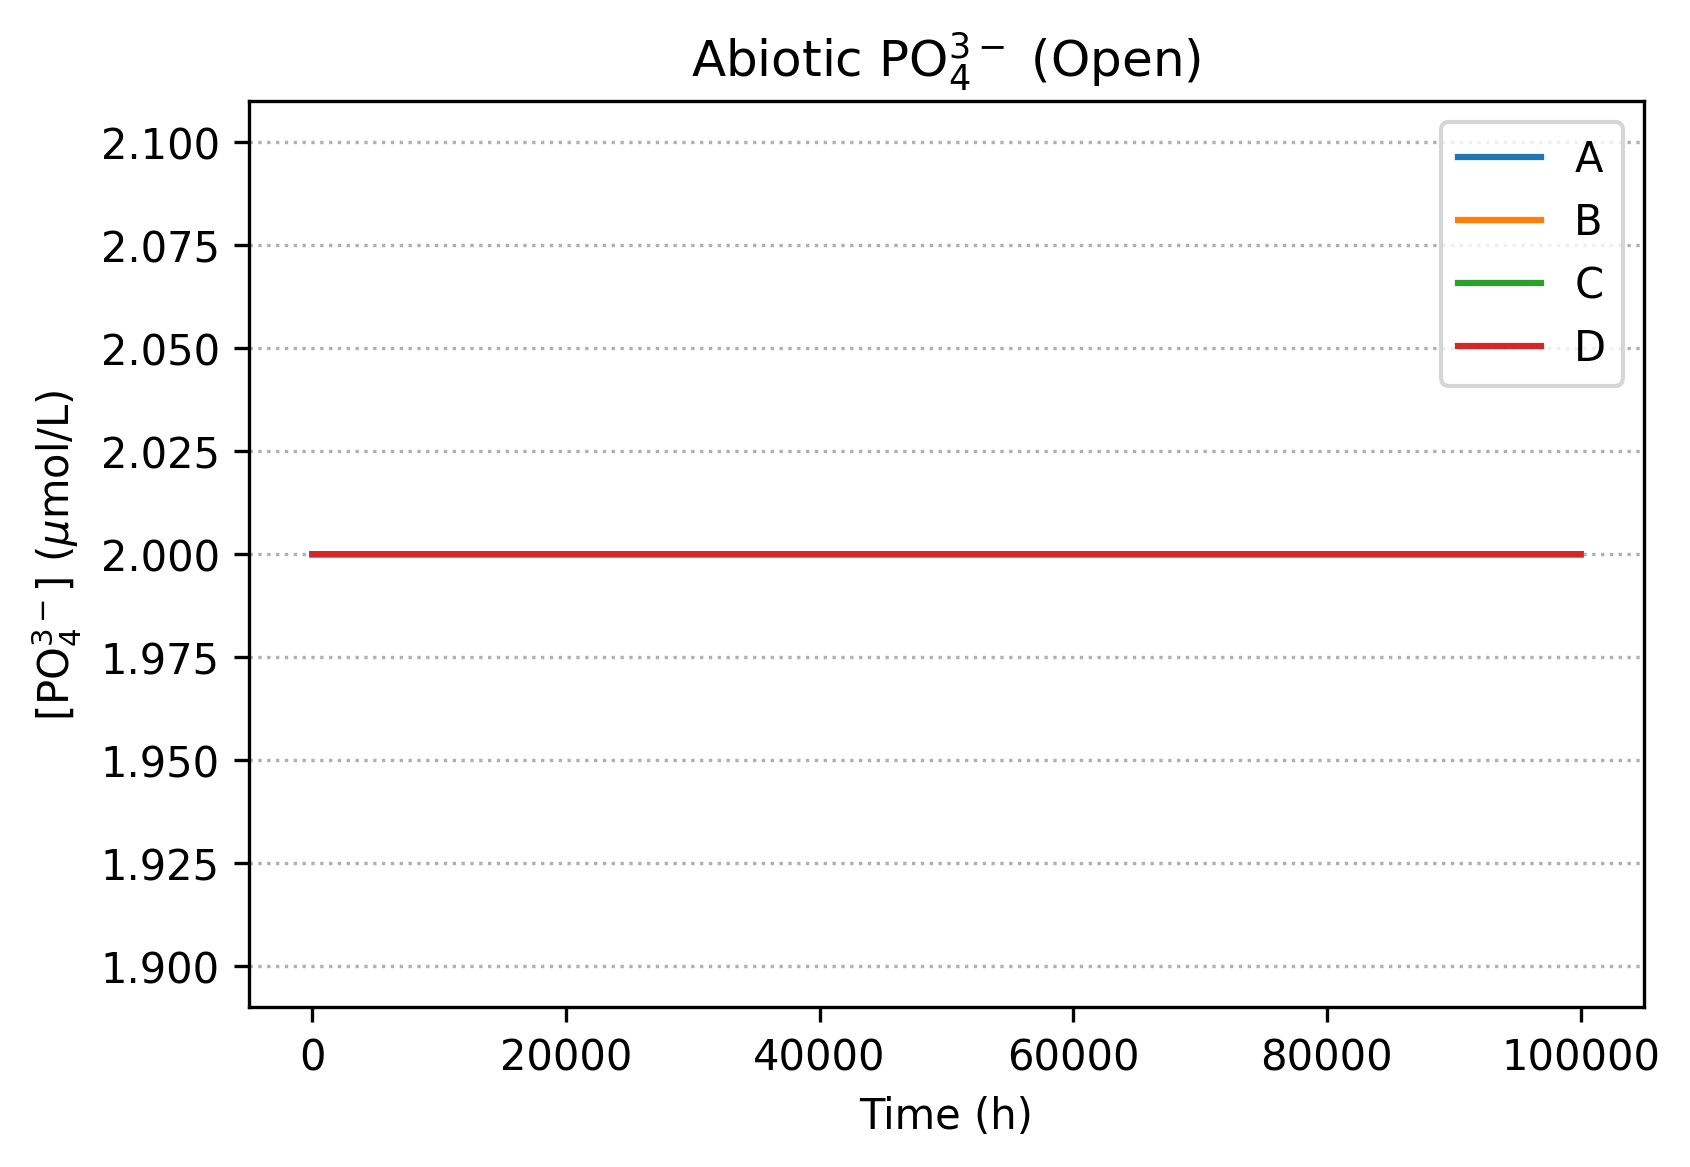

In [8]:
Plot = plt.figure(figsize = [6, 4]) # Manually widen plot
plt.plot(t_open, solution_open_abiotic, label=letters)
plt.xlabel('Time (h)')
plt.ylabel('[PO$_4^{3-}$] ($\mu$mol/L)')
plt.title('Abiotic PO$_4^{3-}$ (Open)')
plt.legend()

plt.savefig("open_abiotic.pdf")
plt.show()

Boring! The system is at steady-state (s.s.) from the beginning. But it doesn't have to be! Go back and redefine the initial concentrations of each reservoir to new values. Predict the behavior of the system. Re-run each block of code and compare the behavior with the first case. (You may want to adjust the duration over which the model solves!)

Feel free to change initial concentrations wildly! However, note that if you do so, the axes will automatically stretch to fit your most extreme values, and it may be difficult to see the finer details at the low end; in particular, what the final steady-state concentrations are. If you run into this problem, use the following code to check the final concentrations at the end of the run, which you can assume are close to s.s. if the time interval is long enough that all the curves flatten out...

In [9]:
print(solution_open_abiotic[-1]) # use negative numbers to count backwards from the end

[2. 2. 2. 2.]


Let's make a slight adjustment, which arguably makes the system a better analog for the real ocean over geologically short timescales (millenia or less). Instead of incorporating an external influx and "drain," we will close the system and let that extra liter per hour simply cycle back from D into A. For our code, this means we remove EA and DE, replace DAo with DAc, and used the more appropriate t_closed time interval. To see final values, simply remove the # symbol from the last line. This closed condition is the approach we will use going forward, but feel free to design your own models using any combination of open/closed, initial conditions, etc.

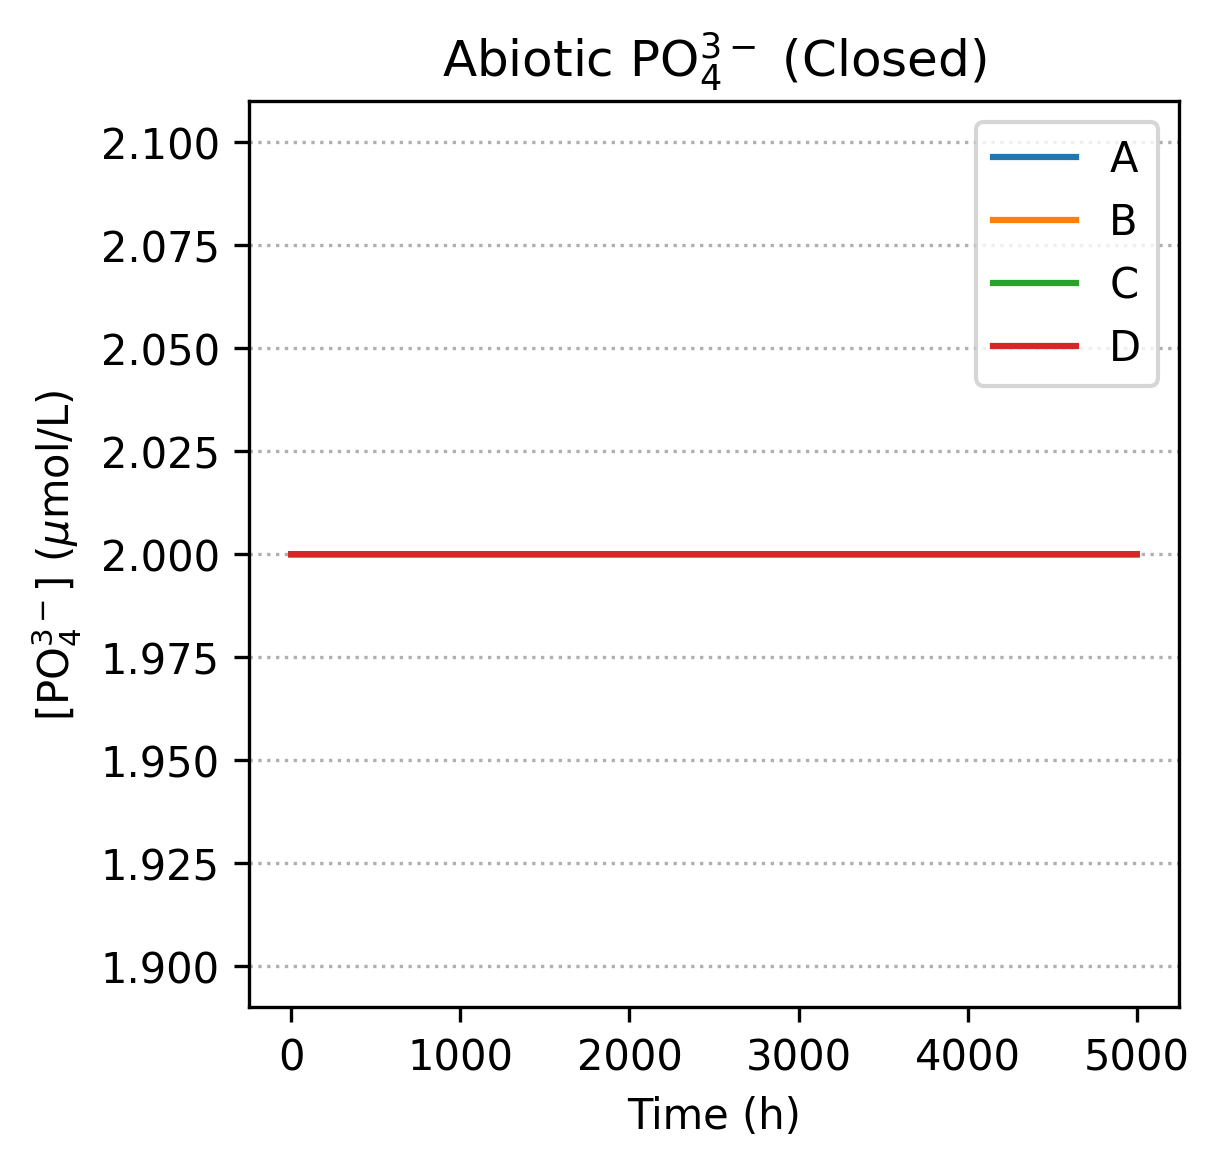

In [10]:
def system_closed_abiotic(y, t_closed):
    A, B, C, D = y
    dAdt = (DAc*D+BA*B-AB*A)/V[0]
    dBdt = (AB*A+CB*C-(BA+BC)*B)/V[1]
    dCdt = (BC*B+DC*D-(CB+CD)*C)/V[2]
    dDdt = (CD*C-(DAc+DC)*D)/V[3]
    return dAdt, dBdt, dCdt, dDdt

solution_closed_abiotic = odeint(system_closed_abiotic, initialConditions, t_closed)
A, B, C, D = solution_closed_abiotic.T

Plot = plt.figure
plt.plot(t_closed, solution_closed_abiotic, label=letters)
plt.xlabel('Time (h)')
plt.ylabel('[PO$_4^{3-}$] ($\mu$mol/L)')
plt.title('Abiotic PO$_4^{3-}$ (Closed)')
plt.legend()

plt.savefig("closed_abiotic.pdf")
plt.show()

#print(solution_closed_abiotic[-1])

## Part II: The Biological Pump

Next, we incorporate biological nutrient cycling. Let's review what's going on here, why it happens in the ocean, and how to incorporate the process into our model.

In addition to carbon dioxide, light, and water, photosynthetic primary producers in the surface ocean need _nutrients_ such as phosphate, nitrate, and iron. In this model we consider only phosphate. When phosphate is consumed and incorporated into organism tissue, its concentration decreases in the immediate vicinity (the surface reservoir). When algae die, their bodies sink to the deep ocean where they are consumed by heterotrophs, "remineralizing" the nutrients and _increasing_ concentration in the corresponding deep reservoir. Without belaboring the biochemical details, we can thus model the net effect of biological nutrient cycling as a transport from the surface to the deep.

Unlike advective physical circulation, which we have seen tends to homogenize reservoirs, this process is _independent of physical water transport_ and can operate _against a concentration gradient,_ so we use the term "pump." Let's add this to the model, noting as well the adjustment for the closed condition

$$\begin{align}
V_A \cdot dA/dt &=BA\cdot B+DAc\cdot D-AB\cdot A-F_{bioA}\\
V_B \cdot dB/dt &=AB\cdot A+CB\cdot C-(BA+BC)\cdot B-F_{bioB}\\
V_C \cdot dC/dt &=BC\cdot B+DC\cdot D-(CB + CD)\cdot C+F_{bioB}\\
V_D \cdot dD/dt &=CD\cdot C-(DAc+DC)\cdot D+F_{bioA}
\end{align}$$

Notice that $F_{bioA}$ and $F_{bioB}$ are not expressed as a product of a volumetric flux and a concentration (which gives an amount flux) but rather as amount fluxes on their own. The tricky part is to actually define these fluxes; there are a few methods we can try, with a focus on _accounting for real trends observed in the ocean._ Namely, that most of the ocean surface is almost completely devoid of nutrients!

### Method 1: Concentration

In this implementation, we assume the biological pump in an ocean basin is proportional to the concentration of nutrients at the surface of that basin. You should think carefully about whether this is a reasonable assuption. In any case, we introduce a proportionality constant $\beta$, which we will say is the same in both reservoirs. Again, if you find this an unrealistic assumption, feel free to adjust the model!

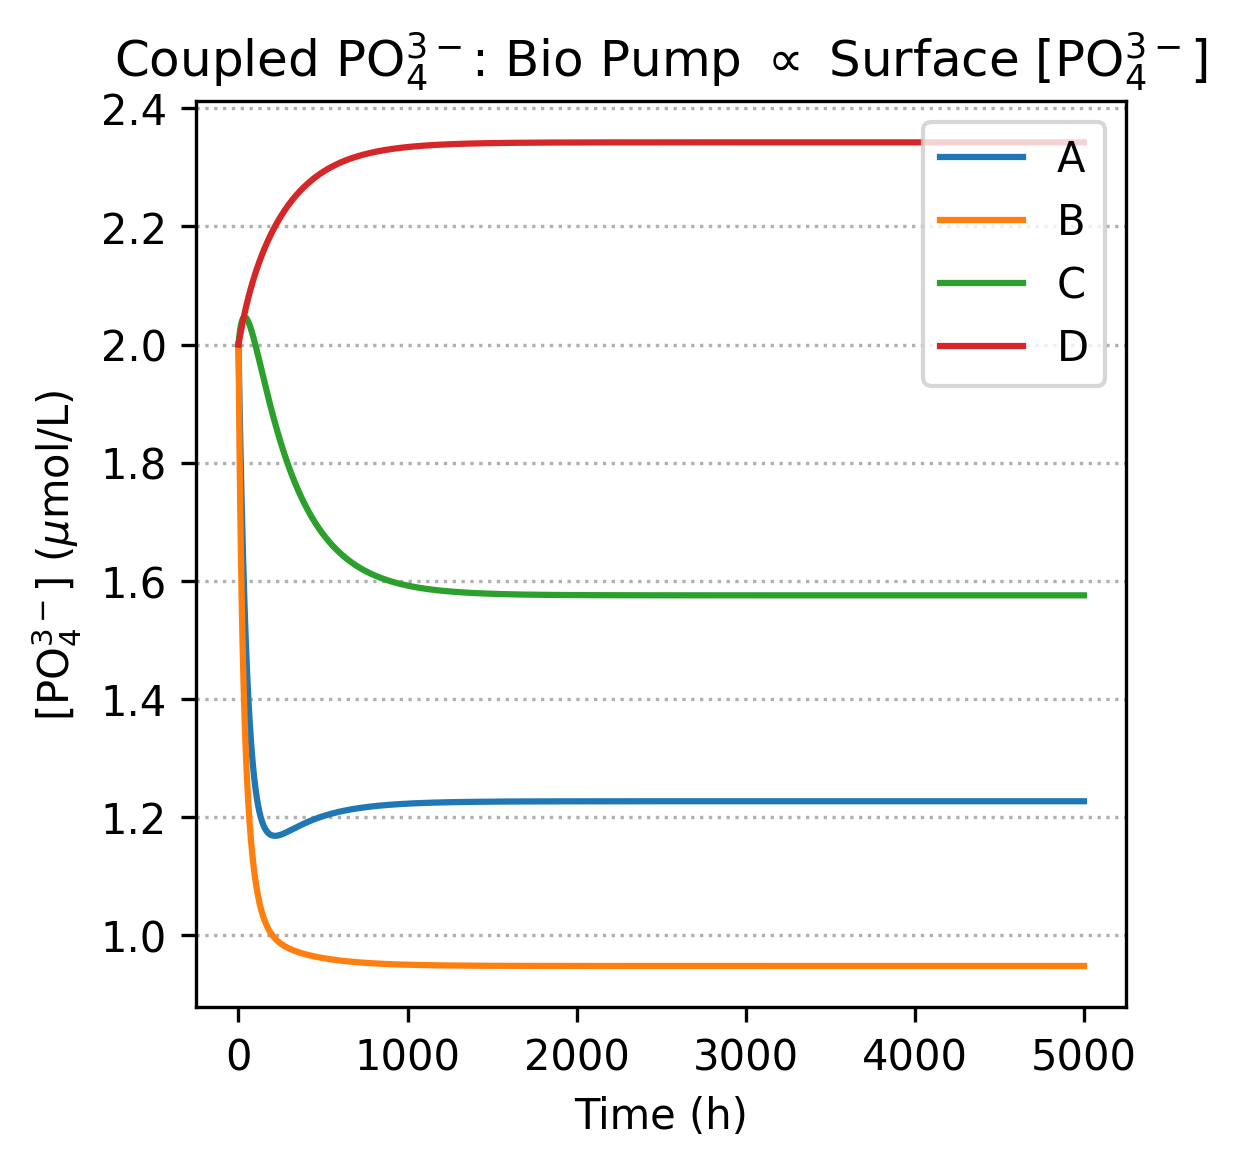

In [11]:
beta_conc = 5 # (L/hr)

def system_conc(y, t_closed):
    A, B, C, D = y
    FbioA_conc = beta_conc*A
    FbioB_conc = beta_conc*B
    dAdt = (DAc*D+BA*B-AB*A-FbioA_conc)/V[0]
    dBdt = (AB*A+CB*C-(BA+BC)*B-FbioB_conc)/V[1]
    dCdt = (BC*B+DC*D-(CB+CD)*C+FbioB_conc)/V[2]
    dDdt = (CD*C-(DAc+DC)*D+FbioA_conc)/V[3]
    return dAdt, dBdt, dCdt, dDdt

solution_conc = odeint(system_conc, initialConditions, t_closed)
A, B, C, D = solution_conc.T

Plot = plt.figure
plt.plot(t_closed, solution_conc, label=letters)
plt.xlabel('Time (h)')
plt.ylabel('[PO$_4^{3-}$] ($\mu$mol/L)')
plt.title('Coupled PO$_4^{3-}$: Bio Pump $\propto$ Surface [PO$_4^{3-}$]')
plt.legend()

plt.savefig("conc.pdf")
plt.show()

#print(solution_conc[-1])

What beta values are necessary for the equilibrium concentrations of the surface reservoirs to reach essentially zero, say, less that 0.01 umol/L? Do the two deep reservoirs end up with roughly the same concentration? What about the surface reservoirs?

### Method 2: Influx

Another approach is to assume that the biological pump is proportional to the total nutrient flux into the corresponding surface reservoir. Let's see what this model predicts:

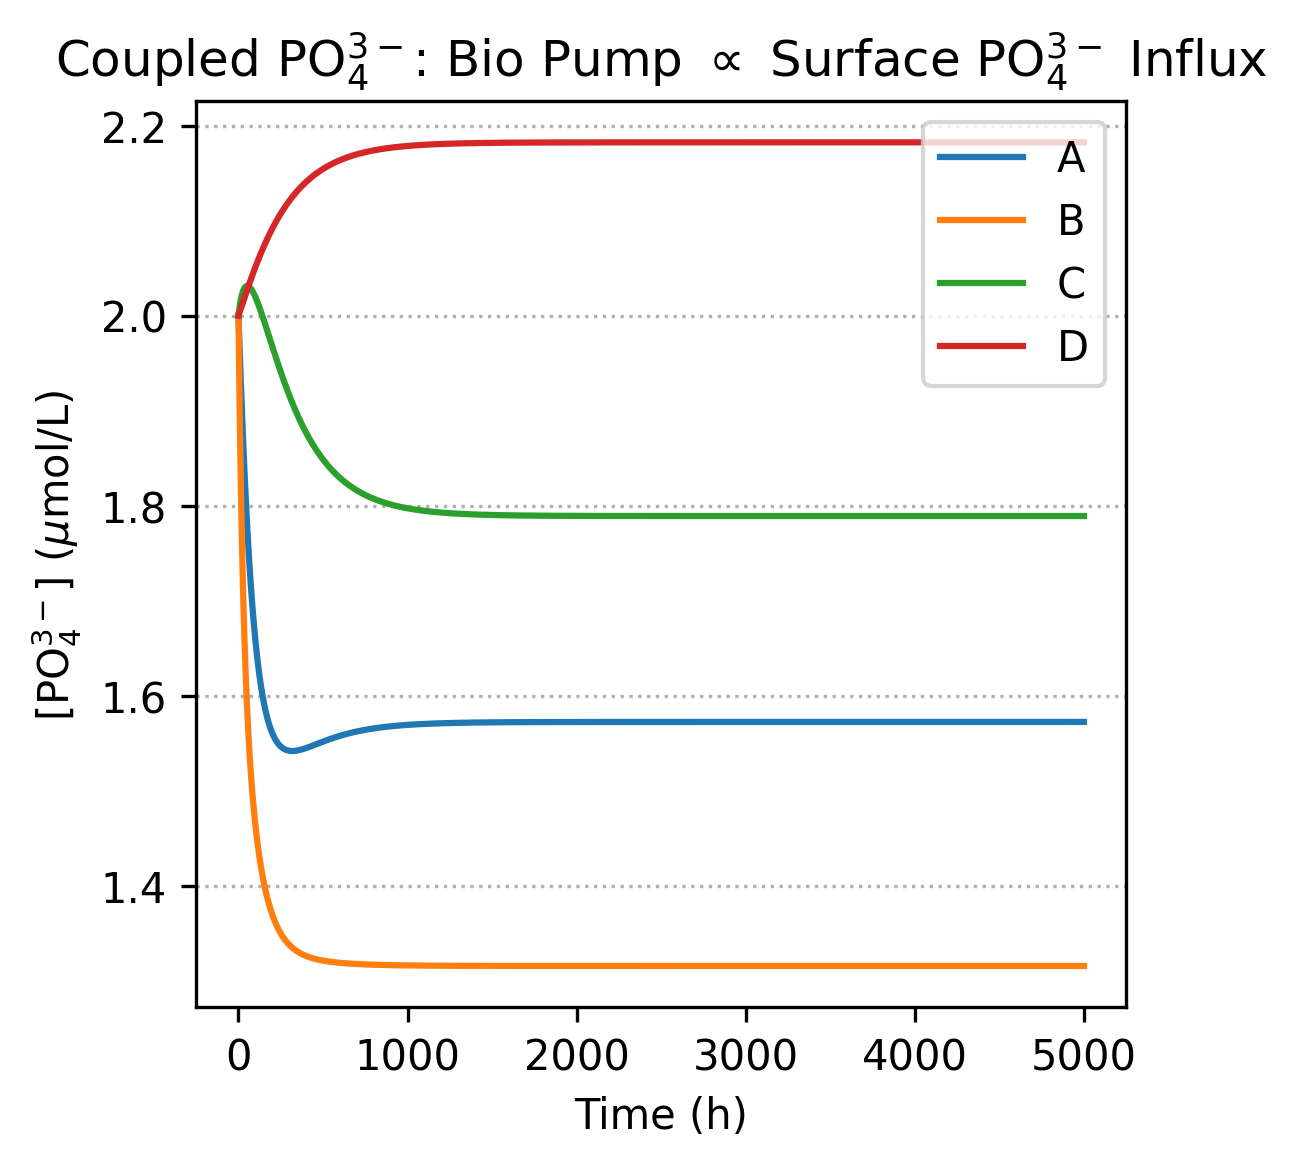

In [12]:
beta_flux = .2

def system_flux(y, t_closed):
    A, B, C, D = y
    FbioA_flux = beta_flux*(DAc*D+BA*B)
    FbioB_flux = beta_flux*(AB*A+CB*C)
    dAdt = (DAc*D+BA*B-AB*A-FbioA_flux)/V[0]
    dBdt = (AB*A+CB*C-(BA+BC)*B-FbioB_flux)/V[1]
    dCdt = (BC*B+DC*D-(CB+CD)*C+FbioB_flux)/V[2]
    dDdt = (CD*C-(DAc+DC)*D+FbioA_flux)/V[3]
    return dAdt, dBdt, dCdt, dDdt

solution_flux = odeint(system_flux, initialConditions, t_closed)
A, B, C, D = solution_flux.T

Plot = plt.figure
plt.plot(t_closed, solution_flux, label=letters)
plt.xlabel('Time (h)')
plt.ylabel('[PO$_4^{3-}$] ($\mu$mol/L)')
plt.title('Coupled PO$_4^{3-}$: Bio Pump $\propto$ Surface PO$_4^{3-}$ Influx')
plt.legend()

plt.savefig("flux.pdf")
plt.show()

#print(solution_flux[-1])

Once again, what $\beta$ values are necessary to reach near-zero surface concentrations? What similarities and/or differences do you notice between the two models? How do you physically interpretat each of the two $\beta$ parameters we defined? Hint: think about units!

## Part III: Oxygen

Finally, we build on the most recent iteration of the coupled model to trace oxygen, whose cycling is linked stoichiometrically to that of nutrients such as phosphate. Also, we incorporate a component of gas exchange which determines the long term steady state of the surface reservoirs. This model has several more parameters to think through, so take your time adjusting, observing, and interpreting this model.

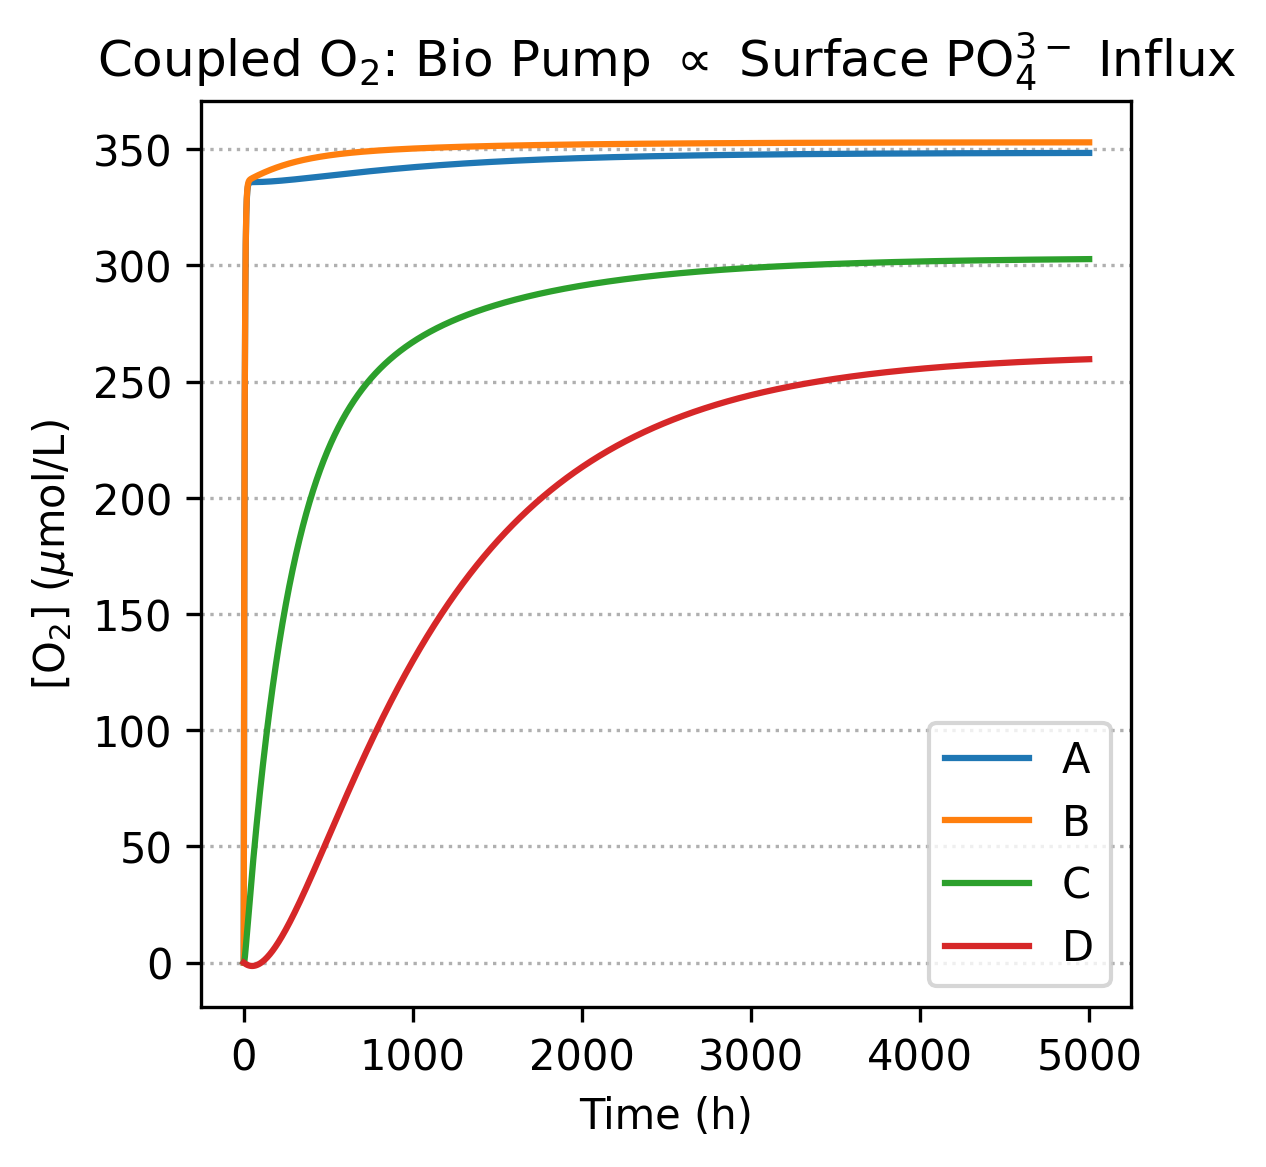

[302.71166704 259.63608829]


In [18]:
# Initial O2 Concentrations (umol/L)
oxygen_0 = (0, 0, 0, 0)
initialConditionsO = oxygen_0 + phosphate_0 # keep track of both

R = 105 # Redfield Ratio: O:P in photosynthesis (positive)
oxy_eq = 350 # Atmospheric Equilibrium Concentration of Oxygen (umol/L)
oxy_eq_rate = 0.2 # Atmospheric Equilibration rate constant

def system_oxy(y, t_closed):
    AO, BO, CO, DO, A, B, C, D = y
    FbioA_flux = beta_flux*(DAc*D+BA*B)
    FbioB_flux = beta_flux*(AB*A+CB*C)
    FbioA_O = -R*FbioA_flux
    FbioB_O = -R*FbioB_flux
    dAOdt = (oxy_eq-AO)*oxy_eq_rate+(DAc*DO+BA*BO-AB*AO-FbioA_O)/V[0]
    dBOdt = (oxy_eq-BO)*oxy_eq_rate+(AB*AO+CB*CO-(BA+BC)*BO-FbioB_O)/V[1]
    dCOdt = (BC*BO+DC*DO-(CB+CD)*CO+FbioB_O)/V[2]
    dDOdt = (CD*CO-(DAc+DC)*DO+FbioA_O)/V[3]
    dAdt = (DAc*D+BA*B-AB*A-FbioA_flux)/V[0]
    dBdt = (AB*A+CB*C-(BA+BC)*B-FbioB_flux)/V[1]
    dCdt = (BC*B+DC*D-(CB+CD)*C+FbioB_flux)/V[2]
    dDdt = (CD*C-(DAc+DC)*D+FbioA_flux)/V[3]
    return dAOdt, dBOdt, dCOdt, dDOdt, dAdt, dBdt, dCdt, dDdt

solution_oxy = odeint(system_oxy, initialConditionsO, t_closed)
AO, BO, CO, DO, A, B, C, D = solution_oxy.T

Plot = plt.figure
plt.plot(t_closed, solution_oxy.T[:4].T, label=letters) # only plot oxygen
plt.xlabel('Time (h)')
plt.ylabel('[O$_2$] ($\mu$mol/L)')
plt.title('Coupled O$_2$: Bio Pump $\propto$ Surface PO$_4^{3-}$ Influx')
plt.legend(loc="lower right")

plt.savefig("oxy.pdf")
plt.show()

print(solution_oxy.T[2:4].T[-1]) # show only the deepwater concentrations (surface is defined)

## Part IV: Summary

To conclude the activity, write a brief summary essay answering the following questions:

For the abiotic physical circulation model, what factors influence the system's initial behavior and long term steady-state conditions? How does the behavior of the open case differ from that of the closed case?

Which definition of the biological flux do you think is a more accurate reflection of real ocean nutrient cycling? Under what spatial or temporal circumstances (if any) would you use these definitions?

How do the two ocean basins differ from each other in the model? Do some cursory research into broad nutrient and oxygen trends in the Atlantic and Pacific oceans. Can this modeling approach provide any physical insight into why these trends might occur?

Include at least 2 plots in your write-up with thorough documentation of the specific model assumptions, equation set-up, parameters, etc.

BONUS: How would you adapt this model to capture the most important processes the circulation of salinity?